In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:
train_deterministic = True # train a deterministic model as starting point 

In [3]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
device

device(type='cuda')

In [4]:
# define data folder
data_dir = "./data"
fig_dir = "./figs"

In [5]:
# compose transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #
if train_deterministic:
    num_epochs = 10
    base_model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 2.2522 Acc 0.4714 ECE 0.2727
Base Model Epoch 1 Avg Loss 0.9718 Acc 0.7195 ECE 0.0313
Base Model Epoch 2 Avg Loss 0.6791 Acc 0.7322 ECE 0.0211
Base Model Epoch 3 Avg Loss 0.6049 Acc 0.7733 ECE 0.0171
Base Model Epoch 4 Avg Loss 0.5580 Acc 0.7806 ECE 0.0175
Base Model Epoch 5 Avg Loss 0.5274 Acc 0.8022 ECE 0.0186
Base Model Epoch 6 Avg Loss 0.4979 Acc 0.8057 ECE 0.0138
Base Model Epoch 7 Avg Loss 0.4726 Acc 0.8114 ECE 0.0147
Base Model Epoch 8 Avg Loss 0.4495 Acc 0.8290 ECE 0.0138
Base Model Epoch 9 Avg Loss 0.4340 Acc 0.8375 ECE 0.0128


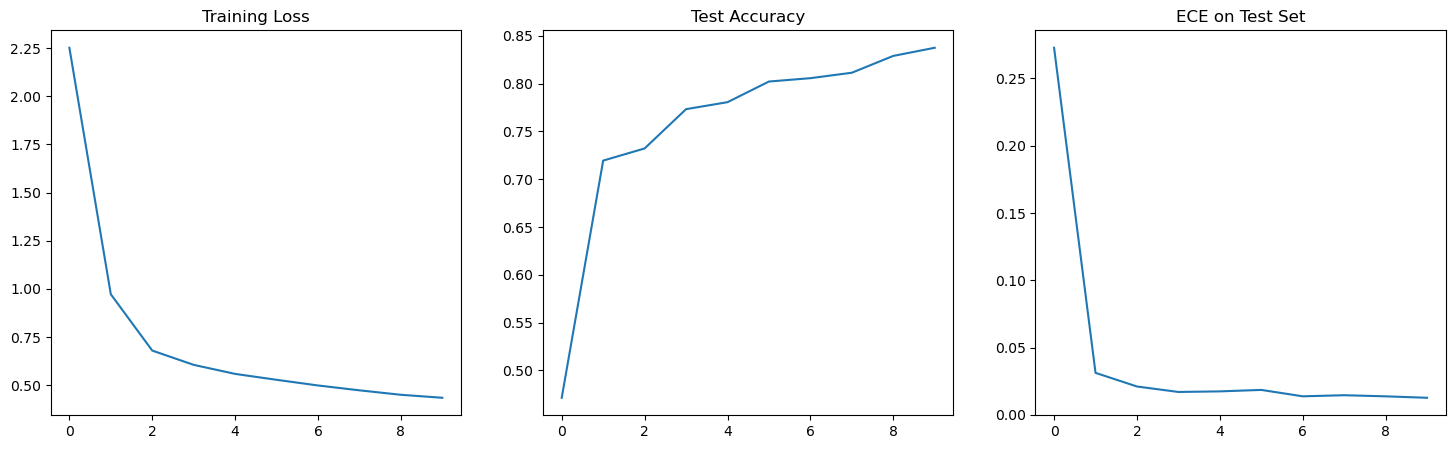

In [7]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "LeNet_FMNIST.jpg")

In [8]:
# ===================================================== #
# =  migrate from base model, finetune and train flow = #
# ===================================================== #

# parameters for base distribution 
NormalParams = lambda scale: {"loc":1.0, "scale":scale}
# flow configurations, List of tuple (type, depth, params)
AffineLayer = [("affine", 1, {"learnable":True})]
GlowStep =  lambda depth, width:[
            ("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
            ("planar2d", 1, {"init_sigma":0.01}),# the second stack of flows (type, depth, params)
            ("flowstep", depth, {"width":width,"keepdim":True}),
            ("planar2d", 1, {"init_sigma":0.01})] 
Planar1d = lambda depth: [("affine", 1), 
            ("planar", depth),
            ("element", 1, {"act":"tanh"})]
# stochastic part for a layer, base distribution name, distribution parameters, flow config 
NormalAffine = ("normal", NormalParams(0.5), AffineLayer)
NormalGlowStep = ("normal", NormalParams(0.5), GlowStep(3, 0.3))
NormalPlanar1d = ("normal", NormalParams(0.5), Planar1d(2))
# flow config for all layers in the model  
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]

In [9]:
def train_sto_model(sto_model:nn.Module, trainloader=None, testloader=None, base_model=None, num_epochs=30, device=None):
    
    if isinstance(base_model, sto_model.DET_MODEL_CLASS):
        sto_model.migrate_from_det_model(base_model)

    det_params, sto_params = sto_model.det_and_sto_params()
    optimizer = optim.Adam([
                    {'params': det_params, 'lr': 2e-4},
                    {'params': sto_params, 'lr': 2e-3}
                ])

    loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
    for epoch in range(num_epochs):
        sto_model.train()
        batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = sto_model(img)
            log_likelihood, kl = sto_model.calc_loss(pred, label)
            loss = -log_likelihood + kl / len(trainloader.dataset)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_ll.append(log_likelihood.item()) 
            batch_kl.append(kl.item()/ len(trainloader.dataset))
        avg = lambda l: sum(l)/len(l)
        avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
        sto_acc = compute_accuracy(sto_model, testloader)
        sto_ece = compute_ece_loss(sto_model, testloader)
        print("Sto Model Epoch {} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                            epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
        loss_list.append(avg_loss)
        ll_list.append(avg_ll)
        kl_list.append(avg_kl)
        acc_list.append(sto_acc)
        ece_list.append(sto_ece)

    return loss_list, ll_list, kl_list, acc_list, ece_list

In [10]:
sto_model = StoLeNet(sto_cfg=sto_model_cfg, colored=False).to(device)
result1 = train_sto_model(sto_model, trainloader, testloader, base_model, num_epochs=30, device=device)

Sto Model Epoch 0 Avg Loss 0.7347 Likelihood -0.7322 KL 0.0025 Acc 0.8097 ECE 0.0865
Sto Model Epoch 1 Avg Loss 0.5529 Likelihood -0.5488 KL 0.0041 Acc 0.8155 ECE 0.1348
Sto Model Epoch 2 Avg Loss 0.4820 Likelihood -0.4766 KL 0.0054 Acc 0.8252 ECE 0.1870
Sto Model Epoch 3 Avg Loss 0.4391 Likelihood -0.4326 KL 0.0065 Acc 0.8247 ECE 0.2325
Sto Model Epoch 4 Avg Loss 0.4095 Likelihood -0.4022 KL 0.0073 Acc 0.8205 ECE 0.2612
Sto Model Epoch 5 Avg Loss 0.3835 Likelihood -0.3755 KL 0.0080 Acc 0.8315 ECE 0.3034
Sto Model Epoch 6 Avg Loss 0.3678 Likelihood -0.3593 KL 0.0086 Acc 0.8198 ECE 0.3246
Sto Model Epoch 7 Avg Loss 0.3516 Likelihood -0.3426 KL 0.0089 Acc 0.8184 ECE 0.3552
Sto Model Epoch 8 Avg Loss 0.3375 Likelihood -0.3280 KL 0.0094 Acc 0.8070 ECE 0.3470
Sto Model Epoch 9 Avg Loss 0.3268 Likelihood -0.3170 KL 0.0097 Acc 0.8088 ECE 0.3671
Sto Model Epoch 10 Avg Loss 0.3134 Likelihood -0.3033 KL 0.0100 Acc 0.8017 ECE 0.3803
Sto Model Epoch 11 Avg Loss 0.3052 Likelihood -0.2949 KL 0.0103 

In [11]:
def plot_results(results, anno=""):
    loss_list, ll_list, kl_list, acc_list, ece_list = results 
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    plt.plot(loss_list)
    plt.title("Negative ELBO")
    plt.subplot(2,3,2)
    plt.plot(ll_list)
    plt.title("Log Likelihood")
    plt.subplot(2,3,3)
    plt.plot(kl_list)
    plt.title("KL Divergence")
    plt.subplot(2,3,4)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(2,3,5)
    plt.plot(ece_list)
    plt.title("ECE on testset")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "{}.jpg".format(anno))

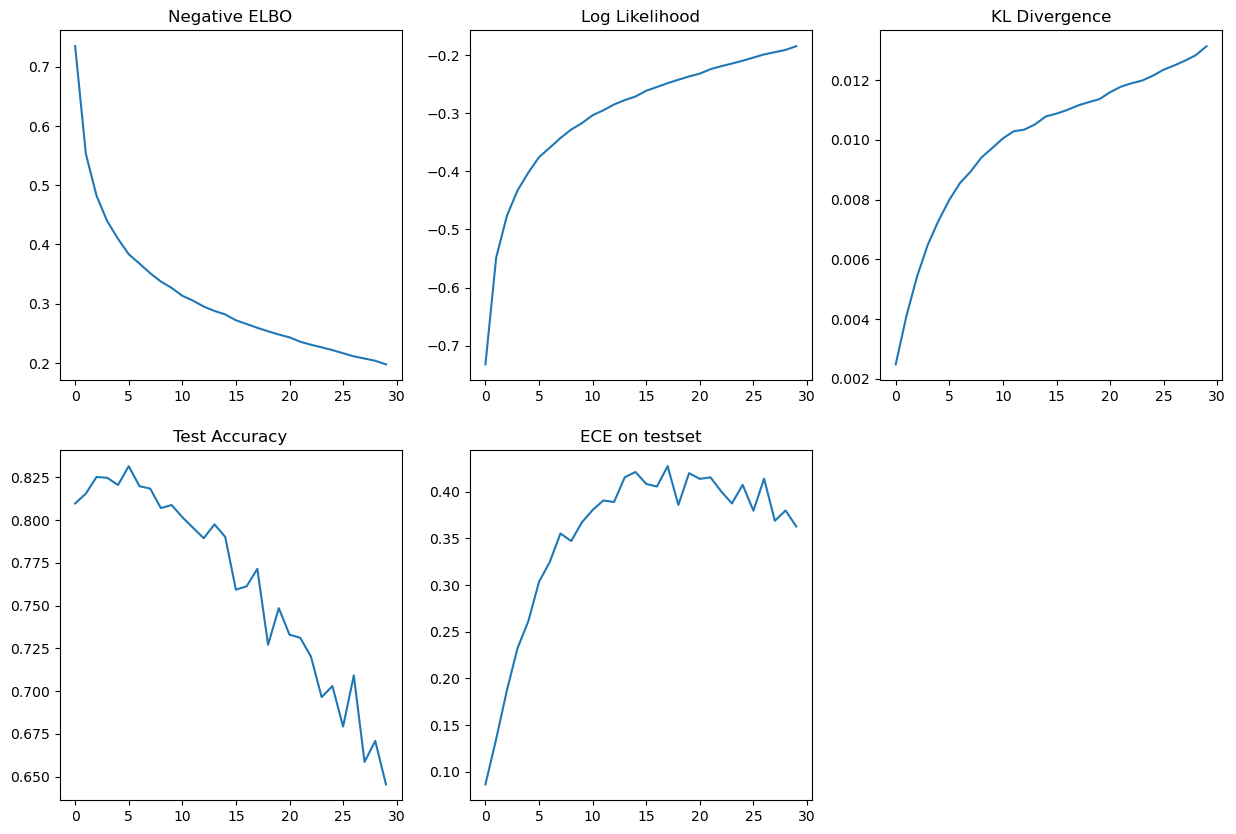

In [12]:
plot_results(result1, anno="StoLeNet_flow_FMNIST")

better results compared to last week (without the "step of flow" in Glow paper)

last time the ECE goes higher as training goes on, this time it's lower than the deterministic LeNet

should probably take the check point arount epoch 10~15, the model seems to overfit after about 20 epochs 

the accuracy increases (84% => 89%): model capacity has been increased by the stochastic part (some has a flow, others don't)

ece is slightly lower (0.01 => 0.004): model is better calibrated, so the flow helps 

if we remove all flows (only keep the base gaussian distribution together with an affine transformation)

the results is almost as good as the complicated model with flow. 

probably the best balanced results are (Acc 0.8903 ECE 0.0051), compared to the one with flow (0.8921 ECE 0.0042)

In [13]:
sto_model_cfg = [NormalAffine, NormalAffine, NormalAffine, NormalAffine, NormalAffine]
sto_model = StoLeNet(sto_cfg=sto_model_cfg, colored=False).to(device)
result2 = train_sto_model(sto_model, trainloader, testloader, base_model, num_epochs=30, device=device)

Sto Model Epoch 0 Avg Loss 0.8493 Likelihood -0.8490 KL 0.0003 Acc 0.7898 ECE 0.0868
Sto Model Epoch 1 Avg Loss 0.6357 Likelihood -0.6347 KL 0.0010 Acc 0.8067 ECE 0.1338
Sto Model Epoch 2 Avg Loss 0.5612 Likelihood -0.5595 KL 0.0017 Acc 0.8141 ECE 0.1830
Sto Model Epoch 3 Avg Loss 0.5124 Likelihood -0.5100 KL 0.0024 Acc 0.8243 ECE 0.2395
Sto Model Epoch 4 Avg Loss 0.4752 Likelihood -0.4724 KL 0.0029 Acc 0.8250 ECE 0.2722
Sto Model Epoch 5 Avg Loss 0.4442 Likelihood -0.4409 KL 0.0033 Acc 0.8377 ECE 0.3218
Sto Model Epoch 6 Avg Loss 0.4226 Likelihood -0.4190 KL 0.0036 Acc 0.8281 ECE 0.3365
Sto Model Epoch 7 Avg Loss 0.4022 Likelihood -0.3983 KL 0.0039 Acc 0.8266 ECE 0.3672
Sto Model Epoch 8 Avg Loss 0.3850 Likelihood -0.3809 KL 0.0041 Acc 0.8245 ECE 0.3782
Sto Model Epoch 9 Avg Loss 0.3703 Likelihood -0.3660 KL 0.0043 Acc 0.8201 ECE 0.3820
Sto Model Epoch 10 Avg Loss 0.3551 Likelihood -0.3507 KL 0.0045 Acc 0.8224 ECE 0.4086
Sto Model Epoch 11 Avg Loss 0.3437 Likelihood -0.3391 KL 0.0046 

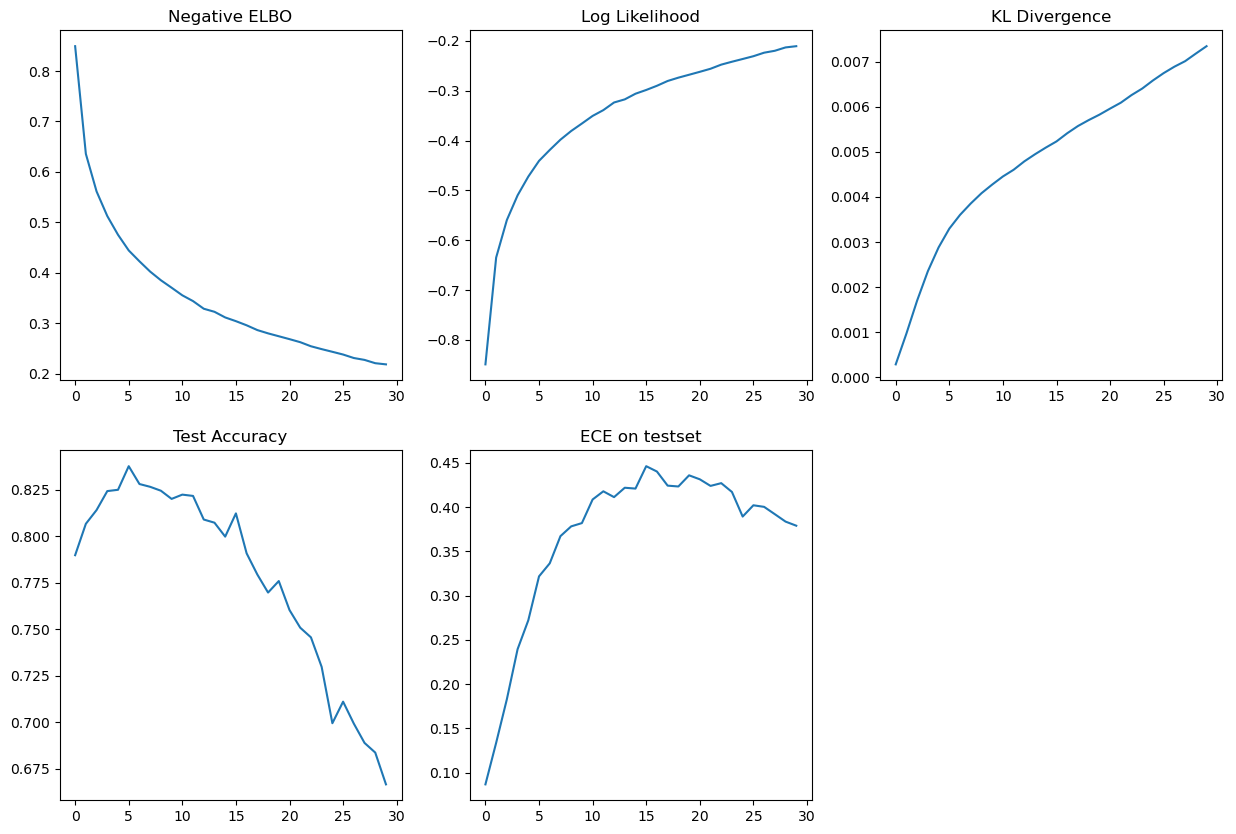

In [14]:
plot_results(result2, anno="StoLeNet_no_flow_FMNIST")

## Redo on CIFAR 10

In [24]:
# transforms adopted from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
if train_deterministic:
    num_epochs = 20
    base_model = LeNet(colored=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 2.2441 Acc 0.2391 ECE 0.0711
Base Model Epoch 1 Avg Loss 2.0593 Acc 0.2877 ECE 0.0388
Base Model Epoch 2 Avg Loss 1.9055 Acc 0.3552 ECE 0.0601
Base Model Epoch 3 Avg Loss 1.7739 Acc 0.3909 ECE 0.0341
Base Model Epoch 4 Avg Loss 1.6879 Acc 0.4383 ECE 0.0612
Base Model Epoch 5 Avg Loss 1.6220 Acc 0.4456 ECE 0.0214
Base Model Epoch 6 Avg Loss 1.5765 Acc 0.4693 ECE 0.0429
Base Model Epoch 7 Avg Loss 1.5375 Acc 0.4893 ECE 0.0460
Base Model Epoch 8 Avg Loss 1.5048 Acc 0.4905 ECE 0.0344
Base Model Epoch 9 Avg Loss 1.4767 Acc 0.5139 ECE 0.0394
Base Model Epoch 10 Avg Loss 1.4492 Acc 0.5115 ECE 0.0307
Base Model Epoch 11 Avg Loss 1.4194 Acc 0.5162 ECE 0.0306
Base Model Epoch 12 Avg Loss 1.3965 Acc 0.5372 ECE 0.0408
Base Model Epoch 13 Avg Loss 1.3659 Acc 0.5462 ECE 0.0286
Base Model Epoch 14 Avg Loss 1.3480 Acc 0.5529 ECE 0.0360
Base Model Epoch 15 Avg Loss 1.3262 Acc 0.5595 ECE 0.0305
Base Model Epoch 16 Avg Loss 1.3046 Acc 0.5746 ECE 0.0366
Base Model Epoch 17 Avg 

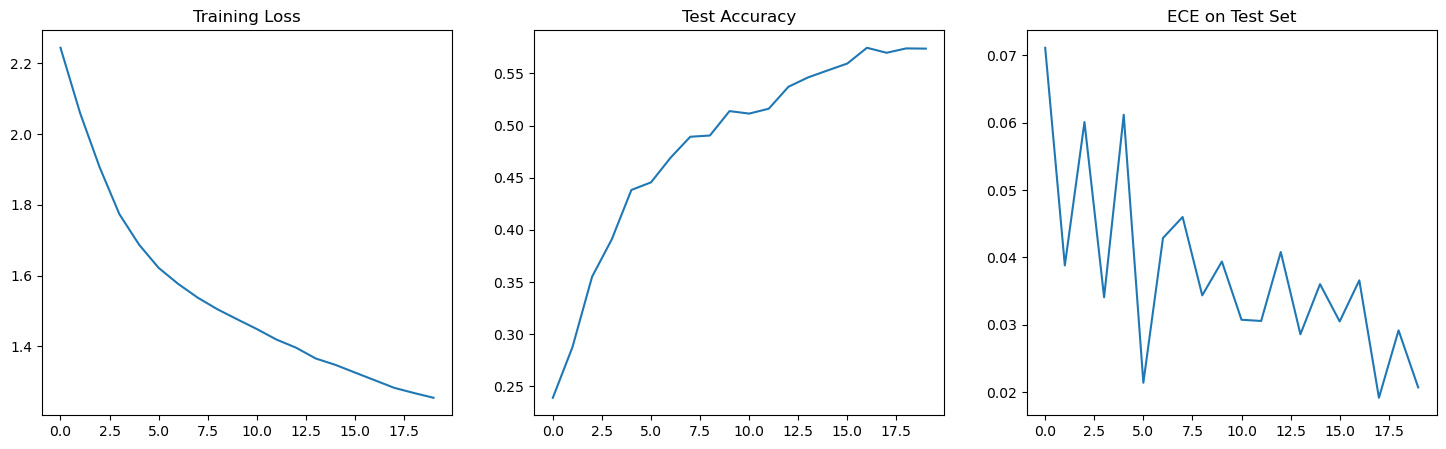

In [26]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "LeNet_CIFAR10.jpg")

In [27]:
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]
sto_model = StoLeNet(sto_cfg=sto_model_cfg, colored=True).to(device)
result3 = train_sto_model(sto_model, trainloader, testloader, base_model, num_epochs=50, device=device)

Sto Model Epoch 0 Avg Loss 1.6126 Likelihood -1.6103 KL 0.0023 Acc 0.5690 ECE 0.1404
Sto Model Epoch 1 Avg Loss 1.4513 Likelihood -1.4480 KL 0.0033 Acc 0.5701 ECE 0.1486
Sto Model Epoch 2 Avg Loss 1.3955 Likelihood -1.3913 KL 0.0042 Acc 0.5670 ECE 0.1520
Sto Model Epoch 3 Avg Loss 1.3606 Likelihood -1.3556 KL 0.0050 Acc 0.5737 ECE 0.1624
Sto Model Epoch 4 Avg Loss 1.3319 Likelihood -1.3262 KL 0.0057 Acc 0.5763 ECE 0.1748
Sto Model Epoch 5 Avg Loss 1.3069 Likelihood -1.3005 KL 0.0064 Acc 0.5789 ECE 0.1888
Sto Model Epoch 6 Avg Loss 1.2914 Likelihood -1.2845 KL 0.0070 Acc 0.5814 ECE 0.1971
Sto Model Epoch 7 Avg Loss 1.2699 Likelihood -1.2624 KL 0.0075 Acc 0.5790 ECE 0.1969
Sto Model Epoch 8 Avg Loss 1.2542 Likelihood -1.2462 KL 0.0080 Acc 0.5801 ECE 0.1898
Sto Model Epoch 9 Avg Loss 1.2326 Likelihood -1.2242 KL 0.0084 Acc 0.5748 ECE 0.2043
Sto Model Epoch 10 Avg Loss 1.2195 Likelihood -1.2107 KL 0.0088 Acc 0.5866 ECE 0.2215
Sto Model Epoch 11 Avg Loss 1.2128 Likelihood -1.2036 KL 0.0092 

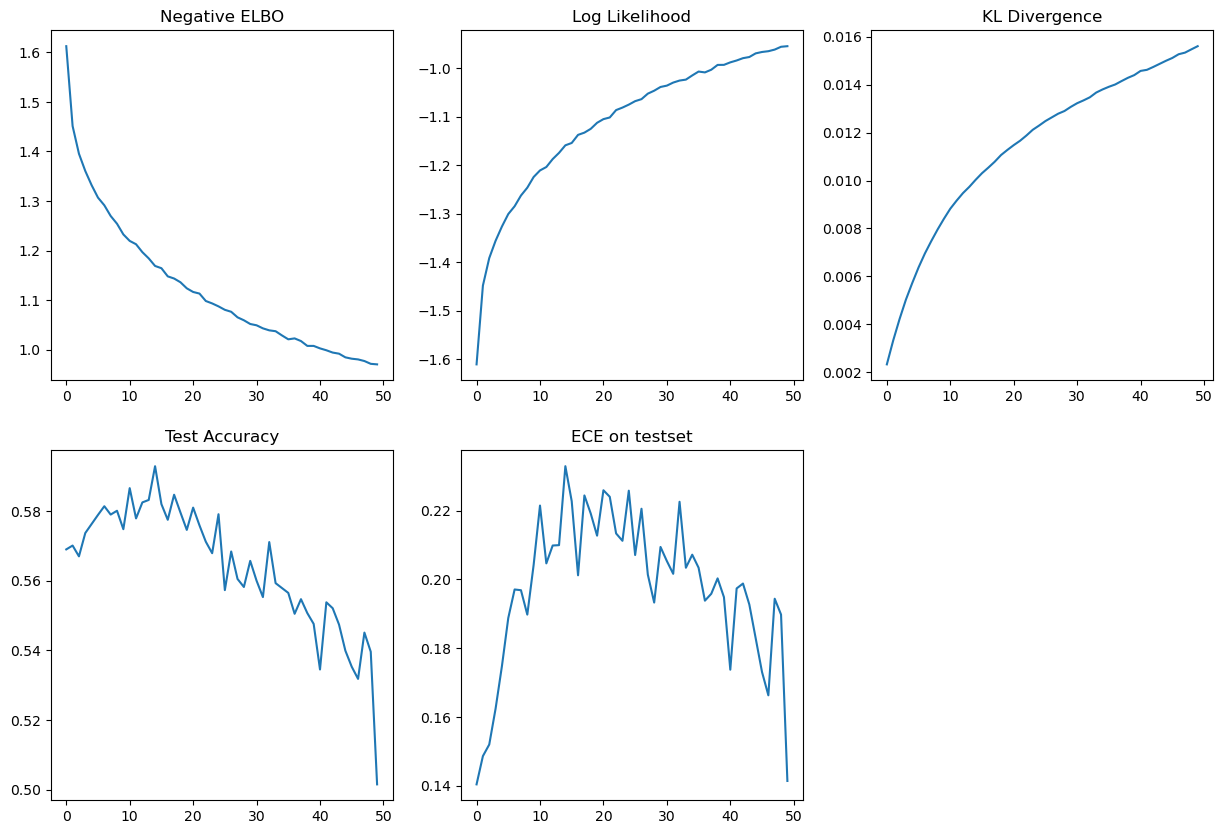

In [28]:
plot_results(result3, anno="StoLeNet_flow_CIFAR10")

In [29]:
sto_model_cfg = [NormalAffine, NormalAffine, NormalAffine, NormalAffine, NormalAffine]
sto_model = StoLeNet(sto_cfg=sto_model_cfg, colored=True).to(device)
result4 = train_sto_model(sto_model, trainloader, testloader, base_model, num_epochs=50, device=device)

Sto Model Epoch 0 Avg Loss 1.6766 Likelihood -1.6765 KL 0.0001 Acc 0.5507 ECE 0.1647
Sto Model Epoch 1 Avg Loss 1.5473 Likelihood -1.5470 KL 0.0003 Acc 0.5622 ECE 0.1918
Sto Model Epoch 2 Avg Loss 1.4945 Likelihood -1.4940 KL 0.0005 Acc 0.5606 ECE 0.1995
Sto Model Epoch 3 Avg Loss 1.4523 Likelihood -1.4515 KL 0.0008 Acc 0.5674 ECE 0.2114
Sto Model Epoch 4 Avg Loss 1.4155 Likelihood -1.4145 KL 0.0010 Acc 0.5650 ECE 0.2288
Sto Model Epoch 5 Avg Loss 1.3853 Likelihood -1.3840 KL 0.0013 Acc 0.5638 ECE 0.2273
Sto Model Epoch 6 Avg Loss 1.3640 Likelihood -1.3624 KL 0.0016 Acc 0.5688 ECE 0.2403
Sto Model Epoch 7 Avg Loss 1.3390 Likelihood -1.3372 KL 0.0019 Acc 0.5656 ECE 0.2414
Sto Model Epoch 8 Avg Loss 1.3186 Likelihood -1.3164 KL 0.0022 Acc 0.5695 ECE 0.2559
Sto Model Epoch 9 Avg Loss 1.3003 Likelihood -1.2979 KL 0.0024 Acc 0.5649 ECE 0.2525
Sto Model Epoch 10 Avg Loss 1.2843 Likelihood -1.2815 KL 0.0027 Acc 0.5656 ECE 0.2575
Sto Model Epoch 11 Avg Loss 1.2676 Likelihood -1.2646 KL 0.0030 

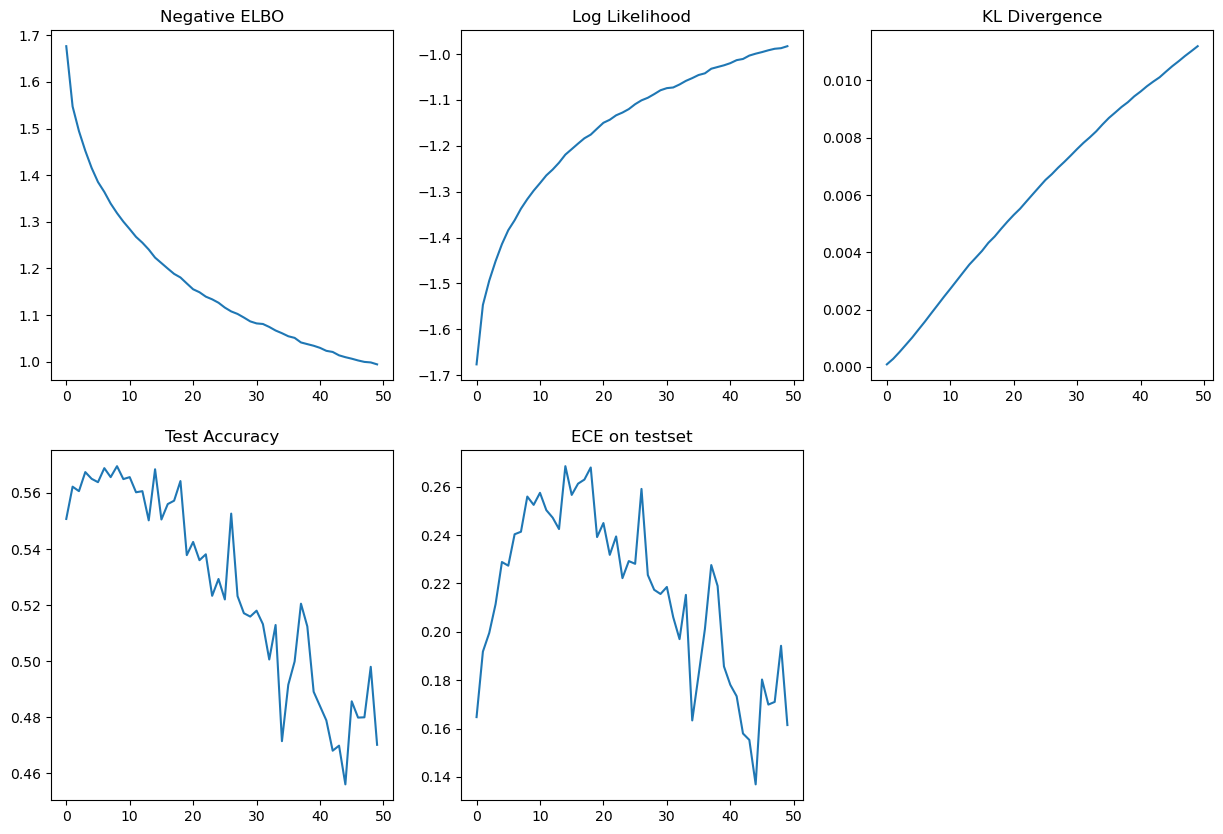

In [30]:
plot_results(result4, anno="StoLeNet_no_flow_CIFAR10")


In [33]:
def plot_multiple_results(result_list, anno_list, fig_dir=None, save_name=None, figsize=(15, 8)):
    fig = plt.figure(figsize=figsize)
    for result in result_list:
        loss_list, ll_list, kl_list, acc_list, ece_list = result 
        plt.subplot(2,3,1)
        plt.plot(loss_list)
        plt.title("Negative ELBO")
        plt.legend(anno_list)
        plt.subplot(2,3,2)
        plt.plot(ll_list)
        plt.title("Log Likelihood")
        plt.legend(anno_list)
        plt.subplot(2,3,3)
        plt.plot(kl_list)
        plt.title("KL Divergence")
        plt.legend(anno_list)
        plt.subplot(2,3,4)
        plt.plot(acc_list)
        plt.title("Test Accuracy")
        plt.legend(anno_list)
        plt.subplot(2,3,5)
        plt.plot(ece_list)
        plt.title("ECE on testset")
        plt.legend(anno_list)

    plt.show()
    fig.tight_layout()
    if os.path.exists(fig_dir) and save_name!=None:
        fig.savefig(fig_dir + "/" + "{}.jpg".format(save_name))


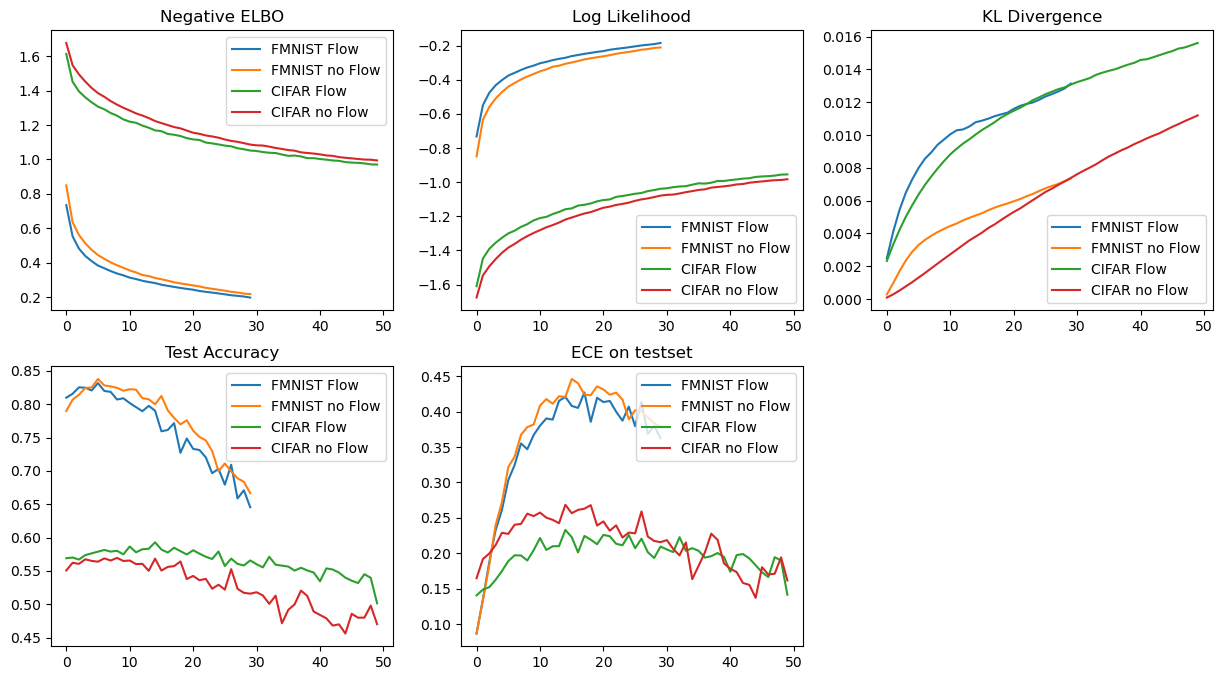

In [34]:
result_list = [result1, result2, result3, result4]
anno_list = ["FMNIST Flow", "FMNIST no Flow", "CIFAR Flow", "CIFAR no Flow"]
plot_multiple_results(result_list, anno_list, fig_dir, "all_results")